Interquartile Ranges: {'urgency_baseline': np.float64(5.25), 'urgency_t': np.float64(6.0), 'frequency_baseline': np.float64(5.0), 'frequency_t': np.float64(7.0), 'pain_baseline': np.float64(4.0), 'pain_t': np.float64(4.25)}
Matched Pairs: [(0, 12), (1, 5), (2, 2), (3, 9), (4, 0), (5, 3), (6, 11)]


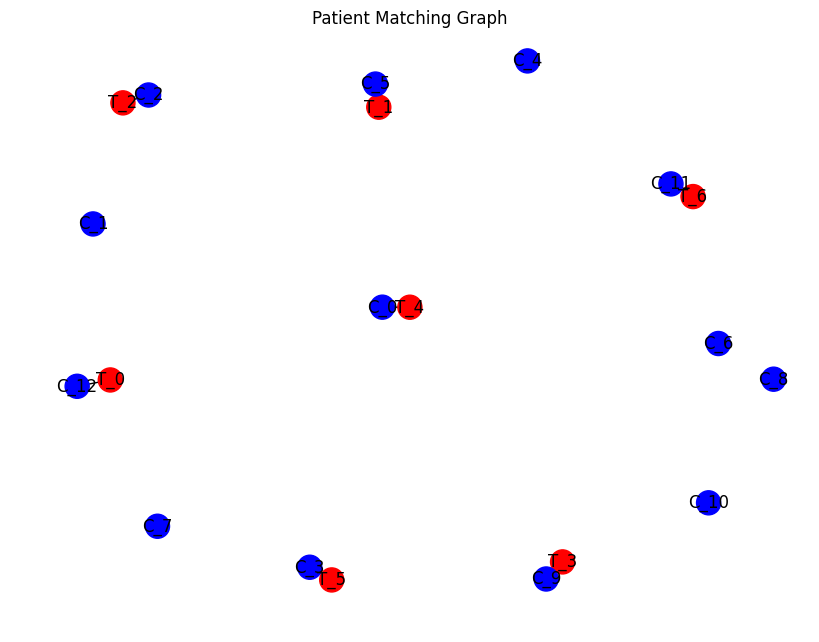

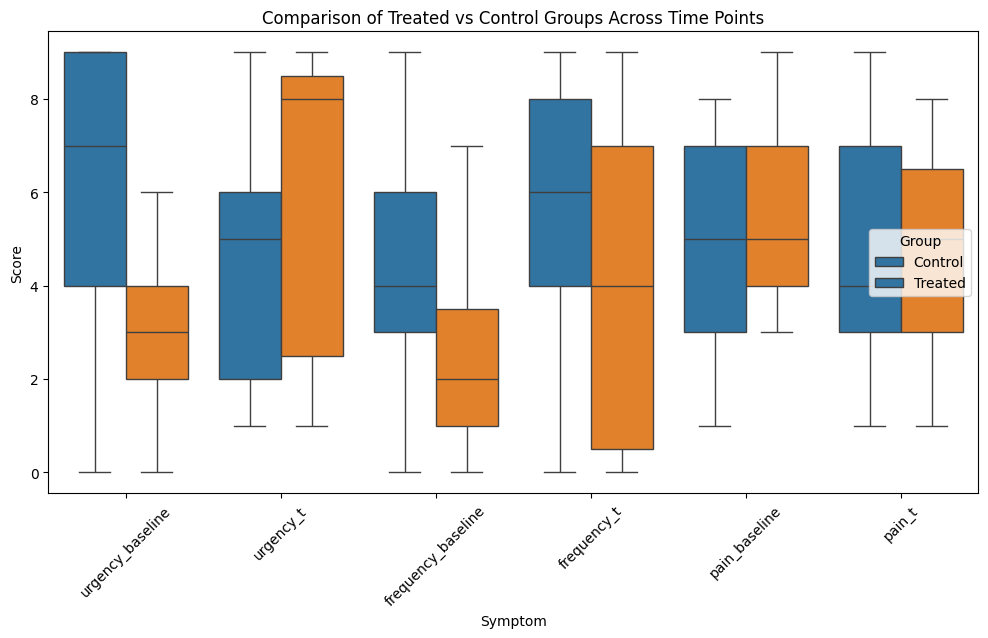

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Step 1: Defining the Matching Framework
data = pd.DataFrame({
    'id': range(1, 21),
    'urgency_baseline': np.random.randint(0, 10, 20),
    'urgency_t': np.random.randint(0, 10, 20),
    'frequency_baseline': np.random.randint(0, 10, 20),
    'frequency_t': np.random.randint(0, 10, 20),
    'pain_baseline': np.random.randint(0, 10, 20),
    'pain_t': np.random.randint(0, 10, 20),
    'age': np.random.randint(20, 80, 20),
    'gender': np.random.choice([0, 1], 20),
    'treated': np.random.choice([0, 1], 20)
})

# Compute IQRs for each measure at baseline and treatment
def compute_iqr(series):
    return np.percentile(series, 75) - np.percentile(series, 25)

iqr_results = {
    'urgency_baseline': compute_iqr(data['urgency_baseline']),
    'urgency_t': compute_iqr(data['urgency_t']),
    'frequency_baseline': compute_iqr(data['frequency_baseline']),
    'frequency_t': compute_iqr(data['frequency_t']),
    'pain_baseline': compute_iqr(data['pain_baseline']),
    'pain_t': compute_iqr(data['pain_t'])
}

print("Interquartile Ranges:", iqr_results)

# Step 2: Risk Set Matching
treated = data[data['treated'] == 1].reset_index(drop=True)
control = data[data['treated'] == 0].reset_index(drop=True)

cov_matrix = np.cov(data[['urgency_baseline', 'urgency_t', 'frequency_baseline', 'frequency_t', 'pain_baseline', 'pain_t']].T)
cov_inv = inv(cov_matrix)

def compute_distance_matrix(treated, control):
    distances = {}
    for i, t in treated.iterrows():
        for j, c in control.iterrows():
            dist = mahalanobis(t[['urgency_baseline', 'urgency_t', 'frequency_baseline', 'frequency_t', 'pain_baseline', 'pain_t']], 
                               c[['urgency_baseline', 'urgency_t', 'frequency_baseline', 'frequency_t', 'pain_baseline', 'pain_t']], 
                               cov_inv)
            distances[(i, j)] = dist
    return distances

distance_matrix = compute_distance_matrix(treated, control)

# Step 3: Optimal Matching via Integer Programming
prob = LpProblem("Balanced_Matching", LpMinimize)
x = {pair: LpVariable(f"x_{pair[0]}_{pair[1]}", cat='Binary') for pair in distance_matrix.keys()}
prob += lpSum(distance_matrix[pair] * x[pair] for pair in distance_matrix.keys())

for i in range(len(treated)):
    prob += lpSum(x[(i, j)] for j in range(len(control)) if (i, j) in x) == 1

for j in range(len(control)):
    prob += lpSum(x[(i, j)] for i in range(len(treated)) if (i, j) in x) <= 1

for attr in ['age', 'gender']:
    treated_sum = lpSum(treated.loc[i, attr] * x[(i, j)] for i, j in x.keys())
    control_sum = lpSum(control.loc[j, attr] * x[(i, j)] for i, j in x.keys())
    prob += treated_sum == control_sum

prob.solve()

matches = [(i, j) for (i, j) in x.keys() if x[(i, j)].value() == 1]
print("Matched Pairs:", matches)

# Visualizations
def plot_matching_graph(treated, control, matches):
    G = nx.Graph()
    for i in range(len(treated)):
        G.add_node(f"T_{i}", color='red')
    for j in range(len(control)):
        G.add_node(f"C_{j}", color='blue')
    for i, j in matches:
        G.add_edge(f"T_{i}", f"C_{j}")
    colors = [G.nodes[n]['color'] for n in G.nodes]
    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color=colors, edge_color='black')
    plt.title("Patient Matching Graph")
    plt.show()

plot_matching_graph(treated, control, matches)

def plot_boxplots(data):
    plt.figure(figsize=(12, 6))
    melted_data = data.melt(id_vars=['treated'], value_vars=['urgency_baseline', 'urgency_t', 'frequency_baseline', 'frequency_t', 'pain_baseline', 'pain_t'], var_name='Symptom', value_name='Score')
    sns.boxplot(x='Symptom', y='Score', hue='treated', data=melted_data)
    plt.title("Comparison of Treated vs Control Groups Across Time Points")
    plt.xticks(rotation=45)
    plt.legend(title='Group', labels=['Control', 'Treated'])
    plt.show()

plot_boxplots(data)
